In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hail as hl
import os.path as osp
import multiprocessing
%run ../../nb.py
%run $TUTORIAL_DIR/reference_genome.py
gab.register_timeop_magic(get_ipython(), 'hail')
data_dir = TUTORIAL_1_QC_DIR
hl.init() 

Running on Apache Spark version 2.4.4
SparkUI available at http://3d498b83ee57:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/tutorial/01-quality-control/hail-20200119-1507-0.2.30-2ae07d872f43.log


In [2]:
# Set this in $SPARK_HOME/spark-env.sh
# hl.spark_context()._conf. get("spark.driver.memory")

<h2><a id="load_raw_data">Load Raw Data</a></h2>

Unlike with PLINK, some accomodations need to be made for Hail in order to properly interpret loci in HapMap Phase III data (HM3).  Hail with throw errors (namely ```loci N is not in range```) if a reference genome is not configured that reflects what is now genetic data based on deprecated genome builds.  A [Hail Reference Genome](https://hail.is/docs/0.2/genetics/hail.genetics.ReferenceGenome.html) definiton is pre-defined for GRCh37 and GRCh38 but HM3 uses hg18 (aka NCBI36).  The [NCBI36 Assembly Statistics](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.12/#/st) site contains everything necessary to do this and also provides a "statistics report" via ftp that can be filtered as follows to generate contig lengths:

```bash
curl -s ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.12_NCBI36/GCF_000001405.12_NCBI36_assembly_stats.txt | grep -E "Primary Assembly.*Chromosome.*assembled-molecule.*total-length"
Primary Assembly	1	Chromosome	assembled-molecule	total-length	247249719
Primary Assembly	2	Chromosome	assembled-molecule	total-length	242951149
...
Primary Assembly	22	Chromosome	assembled-molecule	total-length	49691432
Primary Assembly	X	Chromosome	assembled-molecule	total-length	154913754
Primary Assembly	Y	Chromosome	assembled-molecule	total-length	57772954
```

Other helpful resources:

- [GRCh38 Assembly Statistics](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.39#/st_Primary-Assembly): The statistics there can be compared to the built-in Hail genomes (e.g. ```hl.get_reference('GRCh38')```)
- [UCSC Data FAQ](https://genome.ucsc.edu/FAQ/FAQdownloads.html): This FAQ contains explanations for the meaning of unaligned contigs (see [chr_alt Chromosome](https://genome.ucsc.edu/FAQ/FAQdownloads.html#downloadAlt) and [chrN_random tables](https://genome.ucsc.edu/FAQ/FAQdownloads.html#download10))
- [GRC Assembly Terminology](https://www.ncbi.nlm.nih.gov/grc/help/definitions/): This glossary is also helpful for understanding the PARs and alternate loci defined as special contigs


In [5]:
# Define custom reference for HapMap III data
hl.ReferenceGenome(**hapmap3_hg18_rg())
hl.get_reference('hapmap3_hg18')

ReferenceGenome(name=hapmap3_hg18, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25'], lengths={'1': 247249719, '2': 242951149, '3': 199501827, '4': 191273063, '5': 180857866, '6': 170899992, '7': 158821424, '8': 146274826, '9': 140273252, '10': 135374737, '11': 134452384, '12': 132349534, '13': 114142980, '14': 106368585, '15': 100338915, '16': 88827254, '17': 78774742, '18': 76117153, '19': 63811651, '20': 62435964, '21': 46944323, '22': 49691432, '23': 154913754, '25': 154913754}, x_contigs=['23'], y_contigs=[], mt_contigs=[], par=[])

In [8]:
# Load PLINK dataset using our custom reference
mt_qc0 = hl.import_plink(
    osp.join(data_dir, 'HapMap_3_r3_1.bed'),
    osp.join(data_dir, 'HapMap_3_r3_1.bim'),
    osp.join(data_dir, 'HapMap_3_r3_1.fam'),
    skip_invalid_loci=False,
    reference_genome='hapmap3_hg18'
)

2020-01-15 13:15:14 Hail: INFO: Found 165 samples in fam file.
2020-01-15 13:15:14 Hail: INFO: Found 1457897 variants in bim file.


#### Parititions

Performance will be better if the number of partitions in the original dataset matches the number of CPUs on the system:

In [9]:
mt_qc0.n_partitions()

2020-01-15 13:15:21 Hail: INFO: Coerced sorted dataset


2

In [10]:
# Repartition to n_cpus
mt_qc0 = mt_qc0.repartition(multiprocessing.cpu_count())
mt_qc0.n_partitions()

2020-01-15 13:15:26 Hail: INFO: Coerced sorted dataset


16

#### Cache Result

Hail workflows typically start by materializing raw datasets as native [MatrixTable](https://hail.is/docs/0.2/hail.MatrixTable.html#hail.MatrixTable) structures on-disk.  This improves performance of downstream operations substantially.

In [11]:
# Materialize for downstream operations
# NOTE: The reference genome is stored with the MatrixTable so any updates 
# that reference will not propagate until all datasets are rewritten
mt_qc0.write(osp.join(data_dir, QC0_FILE + '.mt'), overwrite=True)

2020-01-15 13:15:44 Hail: INFO: Coerced sorted dataset
2020-01-15 13:16:17 Hail: INFO: wrote matrix table with 1457897 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_1.mt


In [12]:
%%timeop -o qc0-basic-count
# Show (num variants, num samples)
print(mt_qc0.count())

2020-01-15 13:16:22 Hail: INFO: Coerced sorted dataset


(1457897, 165)
Elapsed time: 5.6 seconds


<h2><a id="step_1">Step 1: Sample/Variant Absence Filter</a></h2>

In [61]:
mt_qc0 = hl.read_matrix_table(osp.join(data_dir, QC0_FILE + '.mt'))

In [14]:
hl.variant_qc(hl.sample_qc(mt_qc0)).describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'sample_qc': struct {
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: int64, 
        n_star: int64, 
        r_ti_tv: float64, 
        r_het_hom_var: float64, 
        r_insertion_deletion: float64
    }
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
    'variant_qc': struct {
        AC: array<int32>, 
        AF: array<f

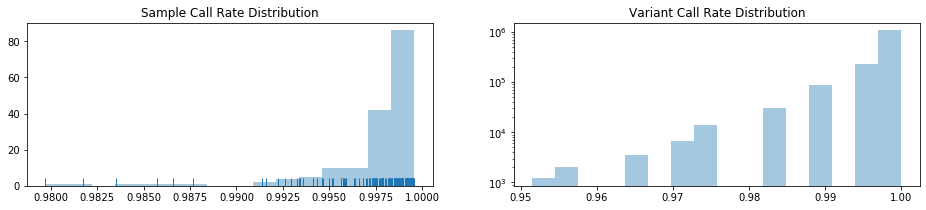

In [15]:
fig, ax = plt.subplots(1, 2)
sns.distplot(hl.sample_qc(mt_qc0).sample_qc.call_rate.collect(), bins=16, rug=True, kde=False, ax=ax[0])
sns.distplot(hl.variant_qc(mt_qc0).variant_qc.call_rate.collect(), bins=16, rug=False, kde=False, ax=ax[1])
fig.set_size_inches(16, 3)
ax[0].set_title('Sample Call Rate Distribution')
ax[1].set_title('Variant Call Rate Distribution')
ax[1].set_yscale('log')

In [135]:
def good_expression(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .98)
    # Attach sample_qc after filtering
    mt = hl.sample_qc(mt)
    return mt

def bad_expression(mt):
    # Attach sample_qc before filtering
    mt = hl.sample_qc(hl.variant_qc(mt))
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .98)
    return mt

def show_sample(mt):
    mtc = mt.filter_cols(mt.s == "NA12739").cols()
    mtc.select(mtc.sample_qc.n_called).show()

show_sample(bad_expression(mt_qc0))
show_sample(good_expression(mt_qc0))

2020-01-15 14:59:50 Hail: INFO: Coerced sorted dataset


s,n_called
str,int64
"""NA12739""",1428313


2020-01-15 14:59:53 Hail: INFO: Coerced sorted dataset


s,n_called
str,int64
"""NA12739""",1402527


In [136]:
%%timeop -o qc1

def qc_1(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .8)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= .8)
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .98)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= .98)
    return mt

mt_qc1 = qc_1(mt_qc0)
print(mt_qc1.count())

(1430443, 165)
Elapsed time: 71.1 seconds


In [38]:
mt_qc1.write(osp.join(data_dir, QC1_FILE + '.mt'), overwrite=True)

2020-01-15 13:45:26 Hail: INFO: wrote matrix table with 1430443 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_5.mt


<h2><a id="step_2">Step 2: Gender Discrepancy</a></h2>

In [137]:
mt_qc1 = hl.read_matrix_table(osp.join(data_dir, QC1_FILE + '.mt'))

In [139]:
%%timeop -o qc2

def qc_2(mt):
    imputed_sex = hl.impute_sex(mt.GT)
    return mt.annotate_cols(is_female=imputed_sex[mt.s].is_female)

mt_qc2 = qc_2(mt_qc1) 
print(mt_qc2.count())

(1430443, 165)
Elapsed time: 0.2 seconds


In [140]:
%%time
get_n_female = lambda mt: mt.aggregate_cols(hl.agg.sum(mt.col.is_female))
get_n_female(mt_qc1), get_n_female(mt_qc2)

CPU times: user 26.8 ms, sys: 674 µs, total: 27.5 ms
Wall time: 1.18 s


(85, 84)

In [141]:
mt_qc2.write(osp.join(data_dir, QC2_FILE + '.mt'), overwrite=True)

2020-01-15 15:02:07 Hail: INFO: wrote matrix table with 1430443 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_6.mt


<h2><a id="step_3">Step 3: Autosomal Variants and MAF Filtering</a></h2>

In [142]:
mt_qc2 = hl.read_matrix_table(osp.join(data_dir, QC2_FILE + '.mt'))

In [143]:
%%time
# Verify that there are 112 founders (implying 53 nonfounders) per plink results
num_founders = mt_qc2.filter_cols(hl.is_missing(mt_qc2.pat_id) & hl.is_missing(mt_qc2.mat_id)).count_cols()
assert num_founders == 112

CPU times: user 18.3 ms, sys: 4.18 ms, total: 22.4 ms
Wall time: 83 ms


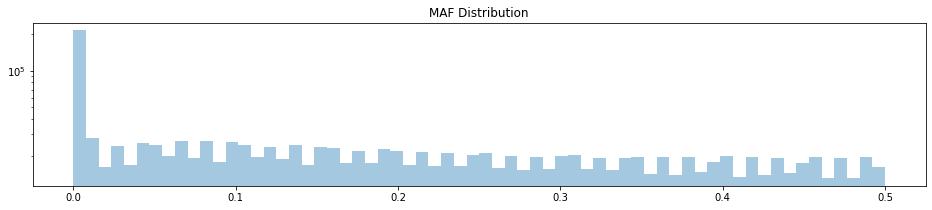

In [156]:
ax = sns.distplot(
    hl.min(mt_qc2.variant_qc.AF).collect(),
    bins=64,
    kde=False
)
ax.set_yscale('log')
ax.set_title('MAF Distribution')
plt.gcf().set_size_inches(16, 3)

In [150]:
%%timeop -o qc3

def get_variants(mt):
    # Base AF calculations only on founders and autosomal variants
    mt = mt.filter_cols(hl.is_missing(mt.pat_id) & hl.is_missing(mt.mat_id))
    mt = mt.filter_rows(hl.int(mt.locus.contig) <= 22)
    # There are always two elements in AF array and if only one allele exists in data,
    # the values will be 0 and 1 (so no explicit check is needed for monoallelic variants)
    mt = hl.variant_qc(mt) # Remember to do this before filtering any expression that may have changed!
    mt = mt.filter_rows(hl.min(mt.variant_qc.AF) >= 0.05)    
    return mt

def qc_3(mt):
    # This could be done by any of the following:
    # 1. Create an hl.set (must .collect() which is slow) containing the bad variant rsids and using mt.filter_rows
    # 2. Use hl.is_defined as a boolean expression to filter rows where one column in left join is missing
    #   - Ex: dataset.filter_rows(hl.is_defined(pruned_variant_table[dataset.row_key]))
    # 3. Use semi_join (or anti_join to drop rather than preserve) intersecting keys
    return mt.semi_join_rows(get_variants(mt).rows())

mt_qc3 = qc_3(mt_qc2)
print(mt_qc3.count())

(1073226, 165)
Elapsed time: 2.4 seconds


In [157]:
mt_qc3.write(osp.join(data_dir, QC3_FILE + '.mt'), overwrite=True)

2020-01-15 15:13:38 Hail: INFO: wrote matrix table with 1073226 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_8.mt


<h2><a id="step_4">Step 4: Hardy-Weinberg Equilibrium Filtering</a></h2>

In [158]:
mt_qc3 = hl.read_matrix_table(osp.join(data_dir, QC3_FILE + '.mt'))

In [159]:
%%timeop -o qc4

def get_variants(mt, threshold, use_founder_controls):
    if use_founder_controls:
        mt = mt.filter_cols(hl.is_missing(mt.pat_id) & hl.is_missing(mt.mat_id))
        # ~mt.iscase will be false if is_case is missing
        mt = mt.filter_cols(~mt.is_case)
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.p_value_hwe > threshold)
    return mt

def qc_4(mt):
    # This could be done by any of the following:
    # 1. Create an hl.set (must .collect() which is slow) containing the bad variant rsids and using mt.filter_rows (slowest by far)
    # 2. Use hl.is_defined as a boolean expression to filter rows where one column in left join is missing
    #   - Ex: mt.filter_cols(hl.is_defined(related_samples_to_remove[mt.col_key]), keep=False)
    #   - See: https://hail.is/docs/0.2/methods/genetics.html#hail.methods.ld_prune
    # 3. Use semi_join (or anti_join to drop rather than preserve) intersecting keys 
    mt = mt.semi_join_rows(get_variants(mt, 1e-6, True).rows())
    mt = mt.semi_join_rows(get_variants(mt, 1e-10, False).rows())
    return mt

mt_qc4 = qc_4(mt_qc3)
print(mt_qc4.count())

(1073226, 165)
Elapsed time: 6.6 seconds


In [160]:
mt_qc4.write(osp.join(data_dir, QC4_FILE + '.mt'), overwrite=True)

2020-01-15 15:15:51 Hail: INFO: wrote matrix table with 1073226 rows and 165 columns in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_9.mt


<h2><a id="step_5">Step 5: Heterozygosity Filtering</a></h2>

In [2]:
mt_qc4 = hl.read_matrix_table(osp.join(data_dir, QC4_FILE + '.mt'))

In [3]:
# Use the handy Hail interval parser to define some genomic regions to ignore due to known inversion 
# mutation rates (these mutations bifurcate the LD correlation structure in a population):
# * equivalent to --exclude inversion.txt --range in tutorial
intervals = [
    hl.parse_locus_interval(i, reference_genome='hapmap3_hg18') 
    for i in ['[6:25.5M-6:33.5M]', '[8:8135K-12M]', '[17:40.9M-17:45M]']
]
pd.DataFrame([hl.eval(i).__dict__ for i in intervals]).rename(columns=lambda c: c.replace('_', '', 1))

,point_type,start,end,includes_start,includes_end
0,locus<hapmap3_hg18>,6:25500000,6:33500000,True,True
1,locus<hapmap3_hg18>,8:8135000,8:12000000,True,True
2,locus<hapmap3_hg18>,17:40900000,17:45000000,True,True


In [4]:
%%timeop -o qc5

def get_variants(mt):
    mt = mt.filter_cols(hl.is_missing(mt.pat_id) & hl.is_missing(mt.mat_id))
    mt = hl.filter_intervals(mt, intervals, keep=False)
    return hl.ld_prune(mt.GT, r2=0.2, bp_window_size=500000)

def qc_5_prune(mt):
    # Get pruned variant set
    variants = get_variants(mt)
    mt = mt.filter_rows(hl.is_defined(variants[mt.row_key]))
    
    # Calculate heterozygosity rate using pruned variants
    mt = hl.sample_qc(mt)
    mt = mt.annotate_cols(het_rate=mt.sample_qc.n_het / mt.sample_qc.n_called)
    
    # Identify outliers +/- 3SD from mean het rate
    stats = mt.aggregate_cols(hl.agg.stats(mt.het_rate))
    mt = mt.annotate_cols(het_rate_status=hl.cond(
        (mt.het_rate < stats.mean - stats.stdev * 3) | (mt.het_rate > stats.mean + stats.stdev * 3),
        'outlier', 'ok'
    ))
    return mt

def qc_5_filter(mt, mt_stat):
    # Select outliers and use the corresponding columns in an anti join to original dataset to remove them
    mt_stat = mt_stat.filter_cols(mt_stat.het_rate_status == 'outlier')
    mt = mt.anti_join_cols(mt_stat.cols())
    return mt

mt_qc5_stat = qc_5_prune(mt_qc4)
mt_qc5 = qc_5_filter(mt_qc4, mt_qc5_stat)
print(mt_qc5.count())

2020-01-19 15:07:29 Hail: INFO: ld_prune: running local pruning stage with max queue size of 860371 variants
2020-01-19 15:07:35 Hail: INFO: wrote table with 143883 rows in 16 partitions to file:/tmp/hail.HM1S4cVUWCy3/zVfijXKyEL
2020-01-19 15:07:44 Hail: INFO: Wrote all 36 blocks of 143883 x 112 matrix with block size 4096.
2020-01-19 15:10:27 Hail: INFO: wrote table with 50 rows in 71 partitions to file:/tmp/hail.HM1S4cVUWCy3/9mcVupCytK
2020-01-19 15:10:30 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


(1073226, 163)
Elapsed time: 183.7 seconds


Save the pruned variant table for later tutorials:

In [11]:
mt_qc5_stat.rows().write(osp.join(data_dir, QC5_PRUNED_VARIANTS_FILE + '.ht'))
print("Wrote pruned variants table with shape", mt_qc5_stat.count())

2020-01-19 15:13:36 Hail: INFO: wrote table with 143843 rows in 16 partitions to /home/eczech/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_9.pruned.ht


Wrote pruned variants table with shape (143843, 165)


Visualize the heterozygosity rates with outliers identified:

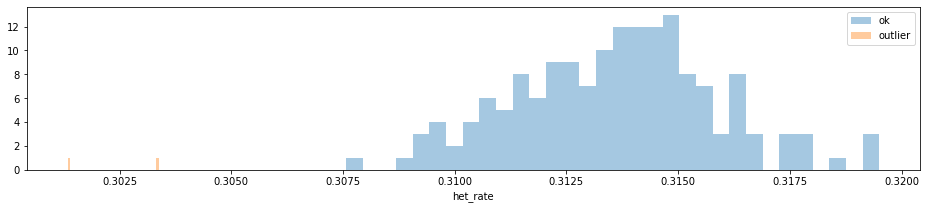

In [242]:
df = pd.DataFrame(mt_qc5_stat.select_cols("het_rate", "het_rate_status").cols().collect())
for k, g in df.groupby('het_rate_status'):
    ax = sns.distplot(g['het_rate'], label=k, kde=False, bins=32)
plt.gcf().set_size_inches(16, 3)
plt.legend()